In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv( 'labs_services.csv')

dfi = df.set_index('lab')

cap = 30

# convert to percentages
for i,row in dfi.iterrows():
    sum = 1
    for c in dfi.columns:
        sum += dfi.loc[i,c]
    for c in dfi.columns:
        dfi.loc[i,c] = (dfi.loc[i,c] / sum)*100
            

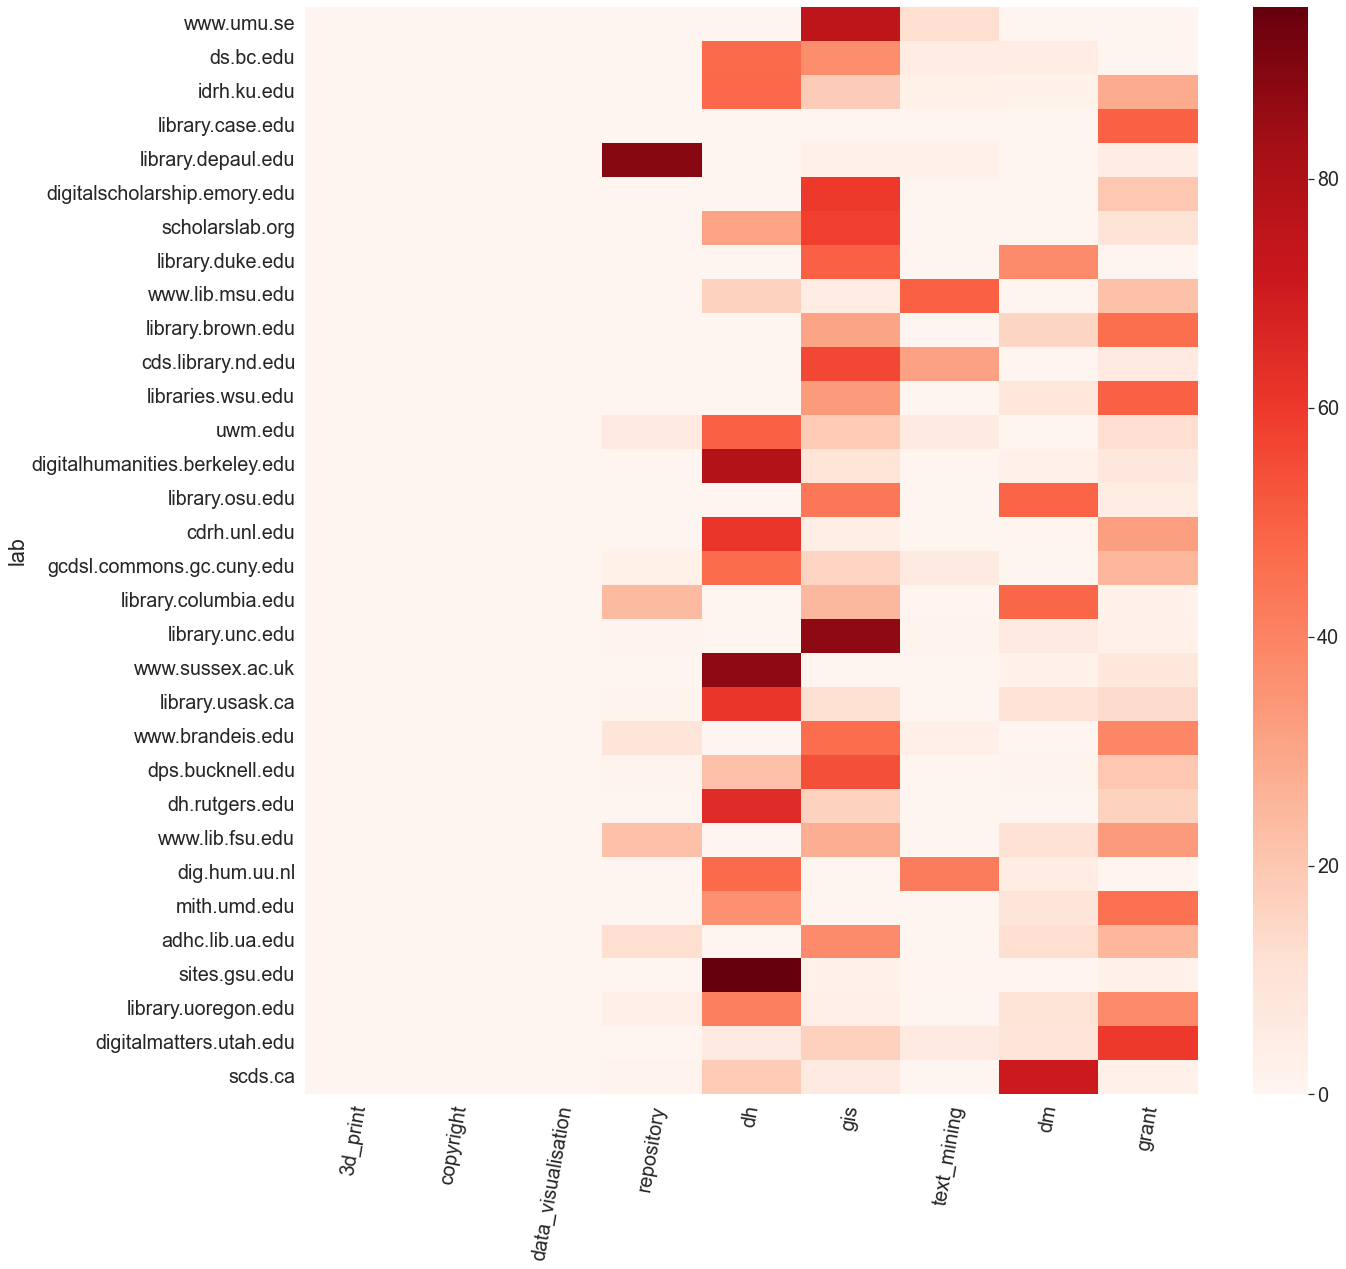

In [2]:
sns.set_theme()

plt.figure(figsize=(20,20))
sns.set(font_scale=1.8)

ax = sns.heatmap( dfi , cmap="Reds" )

plt.xticks(rotation=80)

plt.savefig('heatmap.png' , dpi=300 ,  bbox_inches='tight' )

In [3]:
import requests
import re
from bs4 import BeautifulSoup
import os
from nltk.tokenize import sent_tokenize
import pandas as pd


## Read terms from text file
terms = dict()
with open( 'terms.txt' , encoding = 'utf-8' ) as terms_file:
    for term in terms_file:
        if re.search( r'\w' , term ):
            parts = re.split( r'\t' , term )
            terms[parts[0]] = parts[1]


def find_terms( text ):
    categories = []
    for t in terms:
        if re.search( r'{}'.format(terms[t]) , text , re.IGNORECASE ):
            categories.append(t)
    return categories




dir = "Webpages"
pages = []
labs = []


for path, subdir, file in os.walk(dir):
    for lab in subdir:
        labs.append(lab)

    for f in file:
        if not f.startswith('.'):
            pages.append(os.path.join( path , f))



results = []
all_sentences = []


for i,html_file in enumerate(pages):
    #status = round( 100*(i / len(pages)),2 )
    #print( f'{status}%' , end = '\r')
    #print(html_file)
    parts = re.split( r'[/]' , html_file )
    lab = parts[1]
    with open(html_file, encoding = 'utf-8') as fh:
        page_contents = fh.read()
        soup = BeautifulSoup( page_contents , 'html.parser')

        ## removes non-visible content from the tree
        for s in soup(['style', 'script', 'head', 'title']):
            s.extract()

        full_text = soup.getText()
        full_text = re.sub( r'\s+' , ' ' , full_text.strip() )
        sentences = sent_tokenize(full_text)
        for s in sentences:
            found_terms = find_terms(s)
            if len(found_terms) > 0:
                all_sentences.append( [ lab , s ] )
            for result in found_terms:
                results.append( [ lab , result , 1] )


df = pd.DataFrame( results , columns = ['lab' , 'service' , 'n'] )

labs = df['lab'].unique().tolist()

csv = []

for lab in labs:

    df_lab = df[ df['lab'] == lab ]
    found_services = df_lab.groupby( 'service' )['n'].count().to_dict()
    row = [lab]
    for t in terms:
        row.append(found_services.get(t,0))
    csv.append(row)



column_names = ['lab']
column_names.extend(terms)

df_labs = pd.DataFrame( csv , columns = column_names )
df_labs.to_csv( 'labs_services.csv' , index = False )

df_sentences = pd.DataFrame( all_sentences , columns = [ 'lab' , 'sentence'] )

In [9]:
df_sentences.head()

out = open( 'sentences.txt' , 'w' , encoding='utf-8' )
for lab in labs:
    out.write(f'\n{lab}\n\n')
    df_lab = df_sentences[ df_sentences['lab'] == lab ]
    for i,row in df_lab.iterrows():
        out.write(row['sentence'] + '\n')
        
out.close()
    